In [2]:
#hide
# !pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [3]:
#hide
from fastbook import *
from fastai.vision.widgets import *

In [4]:
key = os.environ.get('AZURE_SEARCH_KEY', 'ef42ea817eb446f9822c929238c17315')

In [5]:
search_images_bing

<function fastbook.search_images_bing(key, term, min_sz=128, max_images=150)>

In [6]:
results = search_images_bing(key, 'grizzly bear')
ims = results.attrgot('content_url')
len(ims)

150

In [7]:
#hide
#ims = ['http://3.bp.blogspot.com/-S1scRCkI3vY/UHzV2kucsPI/AAAAAAAAA-k/YQ5UzHEm9Ss/s1600/Grizzly%2BBear%2BWildlife.jpg']

In [12]:
dest = 'images/grizzly.jpg'
download_url(ims[0], dest)

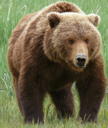

In [13]:
im = Image.open(dest)
im.to_thumb(128,128)

In [16]:
bear_types = 'grizzly','black','teddy'
path = Path('bears')

In [20]:
if not path.exists():
    path.mkdir()
    for o in bear_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{o} bear')
        download_images(dest, urls=results.attrgot('contentUrl'))

In [21]:
fns = get_image_files(path)
fns

(#393) [Path('bears/black/00000000.jpg'),Path('bears/black/00000001.jpg'),Path('bears/black/00000003.jpg'),Path('bears/black/00000004.jpg'),Path('bears/black/00000005.jpg'),Path('bears/black/00000006.jpg'),Path('bears/black/00000007.jpg'),Path('bears/black/00000008.jpg'),Path('bears/black/00000009.jpg'),Path('bears/black/00000010.jpg')...]

In [22]:
failed = verify_images(fns)
failed

(#0) []

In [23]:
failed.map(Path.unlink);

In [24]:
bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [25]:
dls = bears.dataloaders(path)

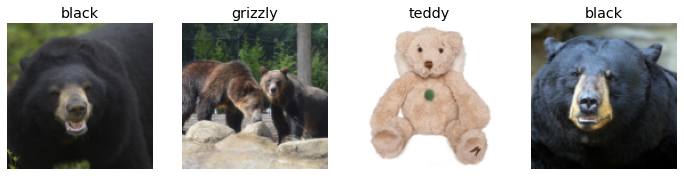

In [31]:
dls.valid.show_batch(max_n=4, nrows=1)

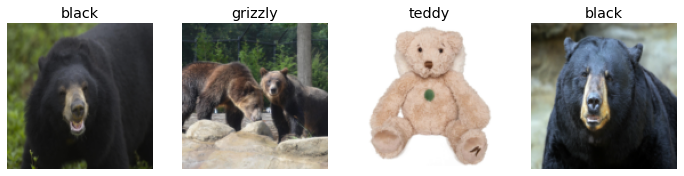

In [32]:
# bears = bears.new(item_tfms=Resize(128, ResizeMethod.Squish))
# dls = bears.dataloaders(path)
# dls.valid.show_batch(max_n=4, nrows=1)

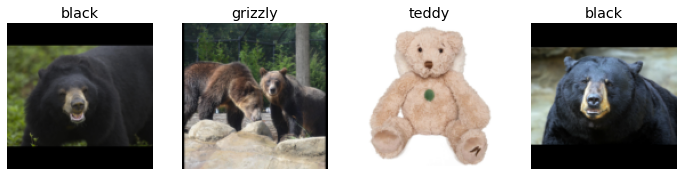

In [33]:
# bears = bears.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
# dls = bears.dataloaders(path)
# dls.valid.show_batch(max_n=4, nrows=1)

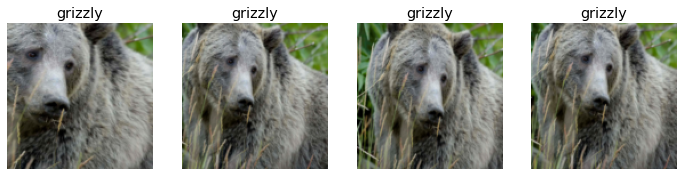

In [34]:
bears = bears.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

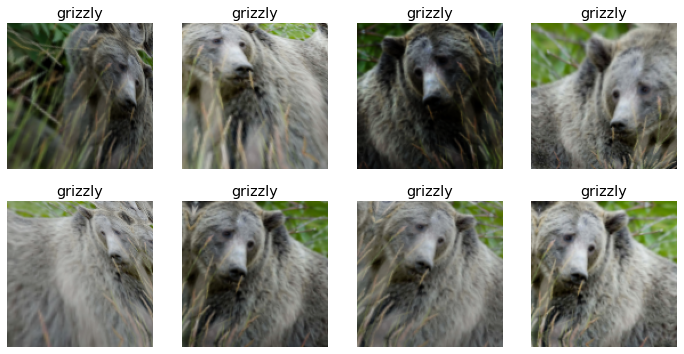

In [35]:
bears = bears.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

In [36]:
bears = bears.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = bears.dataloaders(path)

In [37]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.266842,0.348449,0.192308,00:08


epoch,train_loss,valid_loss,error_rate,time
0,0.180825,0.041812,0.000000,00:08
1,0.126630,0.004941,0.000000,00:08
2,0.104491,0.003886,0.000000,00:08
3,0.079606,0.004299,0.000000,00:09


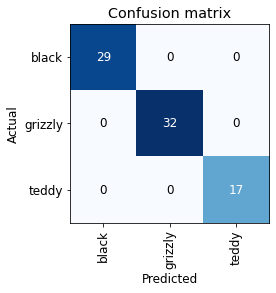

In [38]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

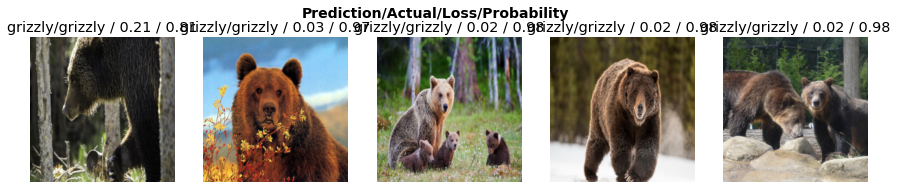

In [39]:
interp.plot_top_losses(5, nrows=1)

In [40]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [41]:
#hide
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

In [42]:
learn.export()